In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import gpytorch

In [2]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [3]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


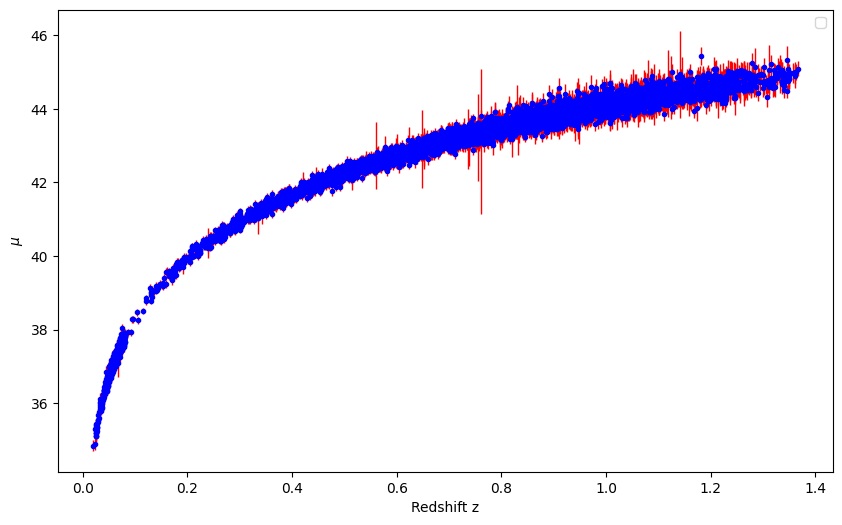

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [5]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [6]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [7]:
len(df_data)

5785

In [8]:
df_data.head()

,zCMB,MU,errors
0,0.01988,34.84680,0.13996
1,0.02321,34.89863,0.16230
2,0.02364,35.28915,0.13201
3,0.02470,35.11988,0.15157
4,0.02471,35.19347,0.13022


In [9]:
z = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values

randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]
len(z), len(y)

(5785, 5785)

In [10]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.01988, 1.36643)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


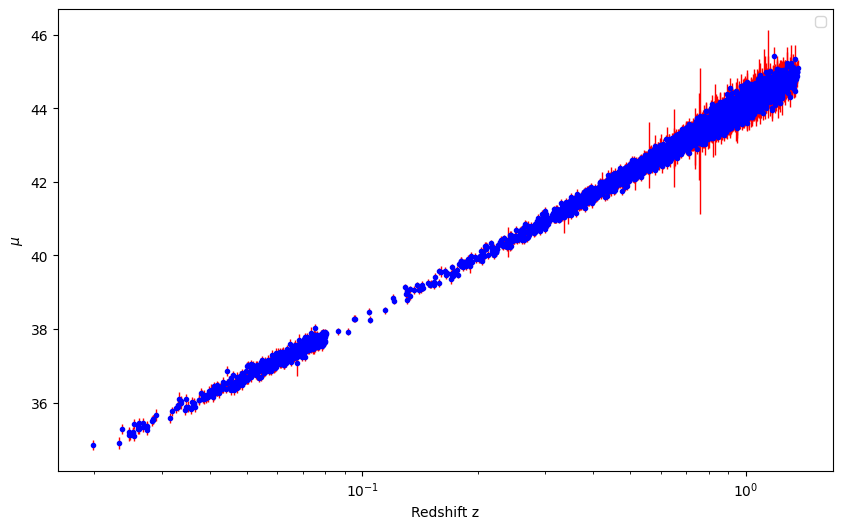

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.xscale('log')
plt.legend()

In [12]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [13]:
# yy = y[:,0].reshape(-1,1)
# zz = z
# split = 0.8
# ntrain = int(split * len(zz))
# indx = [ntrain]
# zz_train, zz_test = np.split(zz, indx)
# yy_train, yy_test = np.split(yy, indx)
# yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
# zz_train = np.append(zz_train, np.array([z[0], z[-1]]))
np.shape(z), np.shape(y)

((5785, 1), (5785, 2))

In [14]:
# x_train = torch.tensor(z_train).reshape(len(z_train),)
# y_train = torch.tensor(y_train)

z_torch = torch.from_numpy(z).float()
y_torch = torch.from_numpy(y).float()

In [15]:
# Definir el modelo de proceso gaussiano
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(z_torch, y_torch, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
#             gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
            gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=2), num_tasks=2, rank=1
#             gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(z_torch, y_torch, likelihood)

In [16]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
loss_history = []
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(z_torch)
    loss = -mll(output, y_torch)
    loss.backward()
    loss_history.append(loss.item())
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.328
Iter 2/100 - Loss: 1.257
Iter 3/100 - Loss: 1.190
Iter 4/100 - Loss: 1.127
Iter 5/100 - Loss: 1.066
Iter 6/100 - Loss: 1.008
Iter 7/100 - Loss: 0.952
Iter 8/100 - Loss: 0.898
Iter 9/100 - Loss: 0.845
Iter 10/100 - Loss: 0.794
Iter 11/100 - Loss: 0.743
Iter 12/100 - Loss: 0.693
Iter 13/100 - Loss: 0.644
Iter 14/100 - Loss: 0.596
Iter 15/100 - Loss: 0.548
Iter 16/100 - Loss: 0.500
Iter 17/100 - Loss: 0.453
Iter 18/100 - Loss: 0.406
Iter 19/100 - Loss: 0.359
Iter 20/100 - Loss: 0.312
Iter 21/100 - Loss: 0.265
Iter 22/100 - Loss: 0.219
Iter 23/100 - Loss: 0.172
Iter 24/100 - Loss: 0.126
Iter 25/100 - Loss: 0.081
Iter 26/100 - Loss: 0.035
Iter 27/100 - Loss: -0.010
Iter 28/100 - Loss: -0.055
Iter 29/100 - Loss: -0.099
Iter 30/100 - Loss: -0.143
Iter 31/100 - Loss: -0.186
Iter 32/100 - Loss: -0.228
Iter 33/100 - Loss: -0.270
Iter 34/100 - Loss: -0.310
Iter 35/100 - Loss: -0.349
Iter 36/100 - Loss: -0.388
Iter 37/100 - Loss: -0.425
Iter 38/100 - Loss: -0.460
Iter 39/1

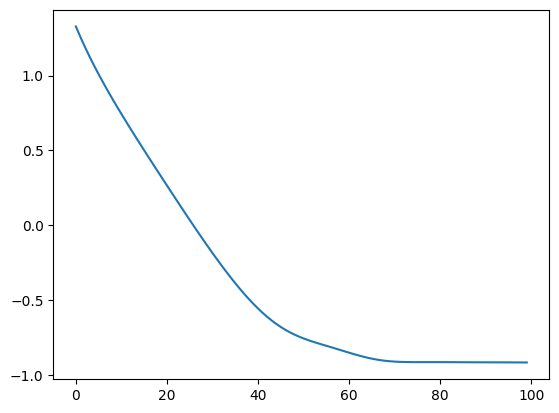

In [17]:
plt.plot(loss_history)

In [18]:
minrange = zmin
maxrange = zmax
x_test = torch.linspace(zmin, zmax+0.05, 50)
np.shape(x_test)

torch.Size([50])

In [19]:
zmax

1.36643

In [20]:
x_test = x_test.reshape(len(x_test), )
# x_test = torch.from_numpy(x_test).float()
np.shape(x_test), type(x_test)

(torch.Size([50]), torch.Tensor)

In [21]:
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [22]:
f_preds = model(x_test)

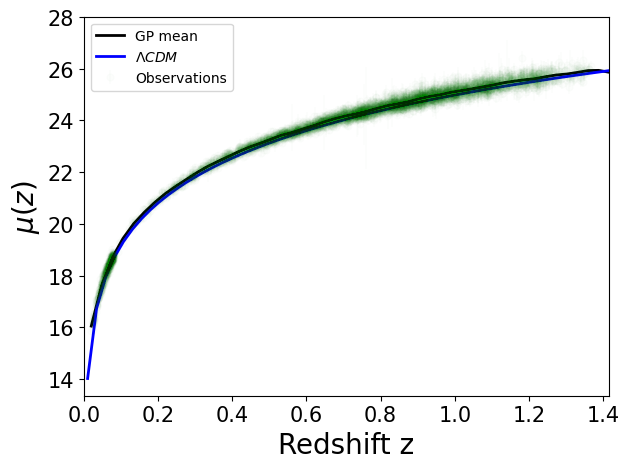

In [26]:
# # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# # See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(x_test)
    f_mean_mu = f_preds.mean[:, 0]
    f_mean_err = f_preds.mean[:, 1]
    f_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(x_test))
#     print(type(observed_pred))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower_mu = lower[:, 0]
    upper_mu = upper[:, 0]
    lower_err = lower[:, 0]
    upper_err = upper[:, 0]
    observed_pred_mean_mu = observed_pred.mean.numpy()[:, 0]
    observed_pred_mean_err = observed_pred.mean.numpy()[:, 1]
#     print(observed_pred.mean.numpy())
    plt.plot(x_test.numpy(), observed_pred_mean_mu-19, color='k', label='GP mean', linewidth=2)
#     # Shade between the lower and upper confidence bounds
#     plt.fill_between(x_test.numpy(), lower_mu-19, upper_mu-19, alpha=0.2, label='GP confidence', color='gray')
#     plt.errorbar(x_test.numpy(), observed_pred_mean_mu-19, yerr=observed_pred_mean_err)

plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b', linewidth=2)
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=10, label='Observations', 
             alpha=0.01)


plt.xlim(0,zmax+0.05)

plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [24]:
np.shape(x_test.numpy()), np.shape(observed_pred_mean_mu), np.shape(observed_pred_mean_err)

((50,), (50,), (50,))